In [1]:
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import matplotlib.cm as cm
from tqdm import tqdm

模型采用单隐层神经网络结构，数学表达为：

$$
\hat{r} = f(W \cdot g(Vr + \mu) + b)
$$

其中：

*   $r \in \mathbb{R}^d$：输入向量（用户/物品评分）
*   $V,W$：权重矩阵
*   $\mu,b$：偏置向量
*   $g,f$：激活函数（通常为Sigmoid）


目标函数设计为带正则化的均方误差：

$$
\min_{\theta} \sum_{i=1}^n \| r^{(i)} - h(r^{(i)};\theta) \|_O^2 + \lambda(\| W \|_F^2 + \| V \|_F^2)
$$

关键参数：

*   $\lambda$：L2正则化系数（默认0.001）
*   激活函数：Sigmoid（编码层）/恒等函数（解码层）
*   优化器：随机梯度下降（SGD）

In [2]:
#定义模型
class AutoRec(nn.Module):
    def __init__(self,input_dim, hidden_dim, variant = 'user'):
        """
        :param input_dim: 输入维度（用户数或物品数）
        :param hidden_dim: 隐层维度
        :param variant: 模型变体 'item' (I-AutoRec) 或 'user' (U-AutoRec)
        """
        super(AutoRec,self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim,input_dim)
        )

    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def get_regularization(self, lambda_reg = 0.01):
        """ 
        计算正则项
        """
        reg = 0
        for name,param in self.named_parameters():
            if 'weight' in name: #只选权重参数部分
                reg += torch.norm(param, p = 2) **2

        return lambda_reg * reg

In [3]:
#定义数据类
class RatingDataset(Dataset):
    def __init__(self,rating_matrix):
        self.rating_matrix = rating_matrix

    def __len__(self):
        return len(self.rating_matrix)
    
    def __getitem__(self,idx):
        return torch.tensor(self.rating_matrix[idx], dtype = torch.float32)

In [4]:
# 定义训练函数
def train_model(model, train_loader, criterion, optimizer,lambda_reg = 1e-4, num_epochs = 100):
    loss_history = []
    model.train()
    pbar = tqdm(range(num_epochs), desc= "Training")
    for epoch in pbar:
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            outputs = model(batch)
            mse_loss = criterion(outputs, batch)
            l2_reg = model.get_regularization(lambda_reg)
            total_loss = mse_loss + l2_reg
            total_loss.backward()
            optimizer.step()
            epoch_loss += total_loss
        pbar.set_postfix({'loss': epoch_loss.item()})
        loss_history += [epoch_loss.item()]

    return loss_history

In [5]:
def generate_random_matrix(rows, cols,min_value,max_value,seed = None):
    """
    Generate random matrix
    Args:
        rows (int): number of rows
        cols (int): number of columns
        min_value (int): min value of matrix
        max_value (int): max value of matrix
        seed (int, optional): seed. Defaults to None.
    Returns:
        np.array: random matrix
    """
    if seed is not None:
        np.random.seed(seed)
    return np.random.randint(min_value,max_value + 1,size = (rows,cols))

In [6]:
# 示例数据和模型训练
np.random.seed(42)
num_users = 100
num_items = 50
ratings_matrix = generate_random_matrix(rows = num_users, cols = num_items, min_value = 0,max_value = 5)
# 创建数据集和数据加载器
dataset = RatingDataset(ratings_matrix)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)
# 初始化模型、损失函数和优化器
hidden_dim = 10  # 隐层维度
model = AutoRec(num_items, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
# 训练模型
loss_history = train_model(model, train_loader, criterion, optimizer, num_epochs = 1000,lambda_reg = 1e-5)

Training: 100%|██████████| 1000/1000 [00:12<00:00, 77.49it/s, loss=13.2]


In [7]:
# 模型预测
user_index = np.random.randint(0, num_users)
user_ratings = torch.tensor(ratings_matrix[user_index], dtype=torch.float32)
predicted_ratings = model(user_ratings)
pd.DataFrame(np.concatenate((user_ratings.detach().numpy().reshape(1,-1),predicted_ratings.detach().numpy().reshape(1,-1)), axis =0))

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,4.000000,3.000000,5.000000,2.00000,2.00000,4.000000,1.000000,2.000000,5.000000,4.000000,...,0.000000,2.000000,1.000000,0.00000,2.000000,4.000000,5.000000,2.000000,1.000000,3.000000
1,4.661274,2.740979,3.189464,1.94146,3.39171,3.240865,0.758816,3.701328,3.787683,3.239216,...,0.851007,2.639428,1.775714,2.60591,1.321997,4.365584,3.307541,4.512519,1.702436,2.098448


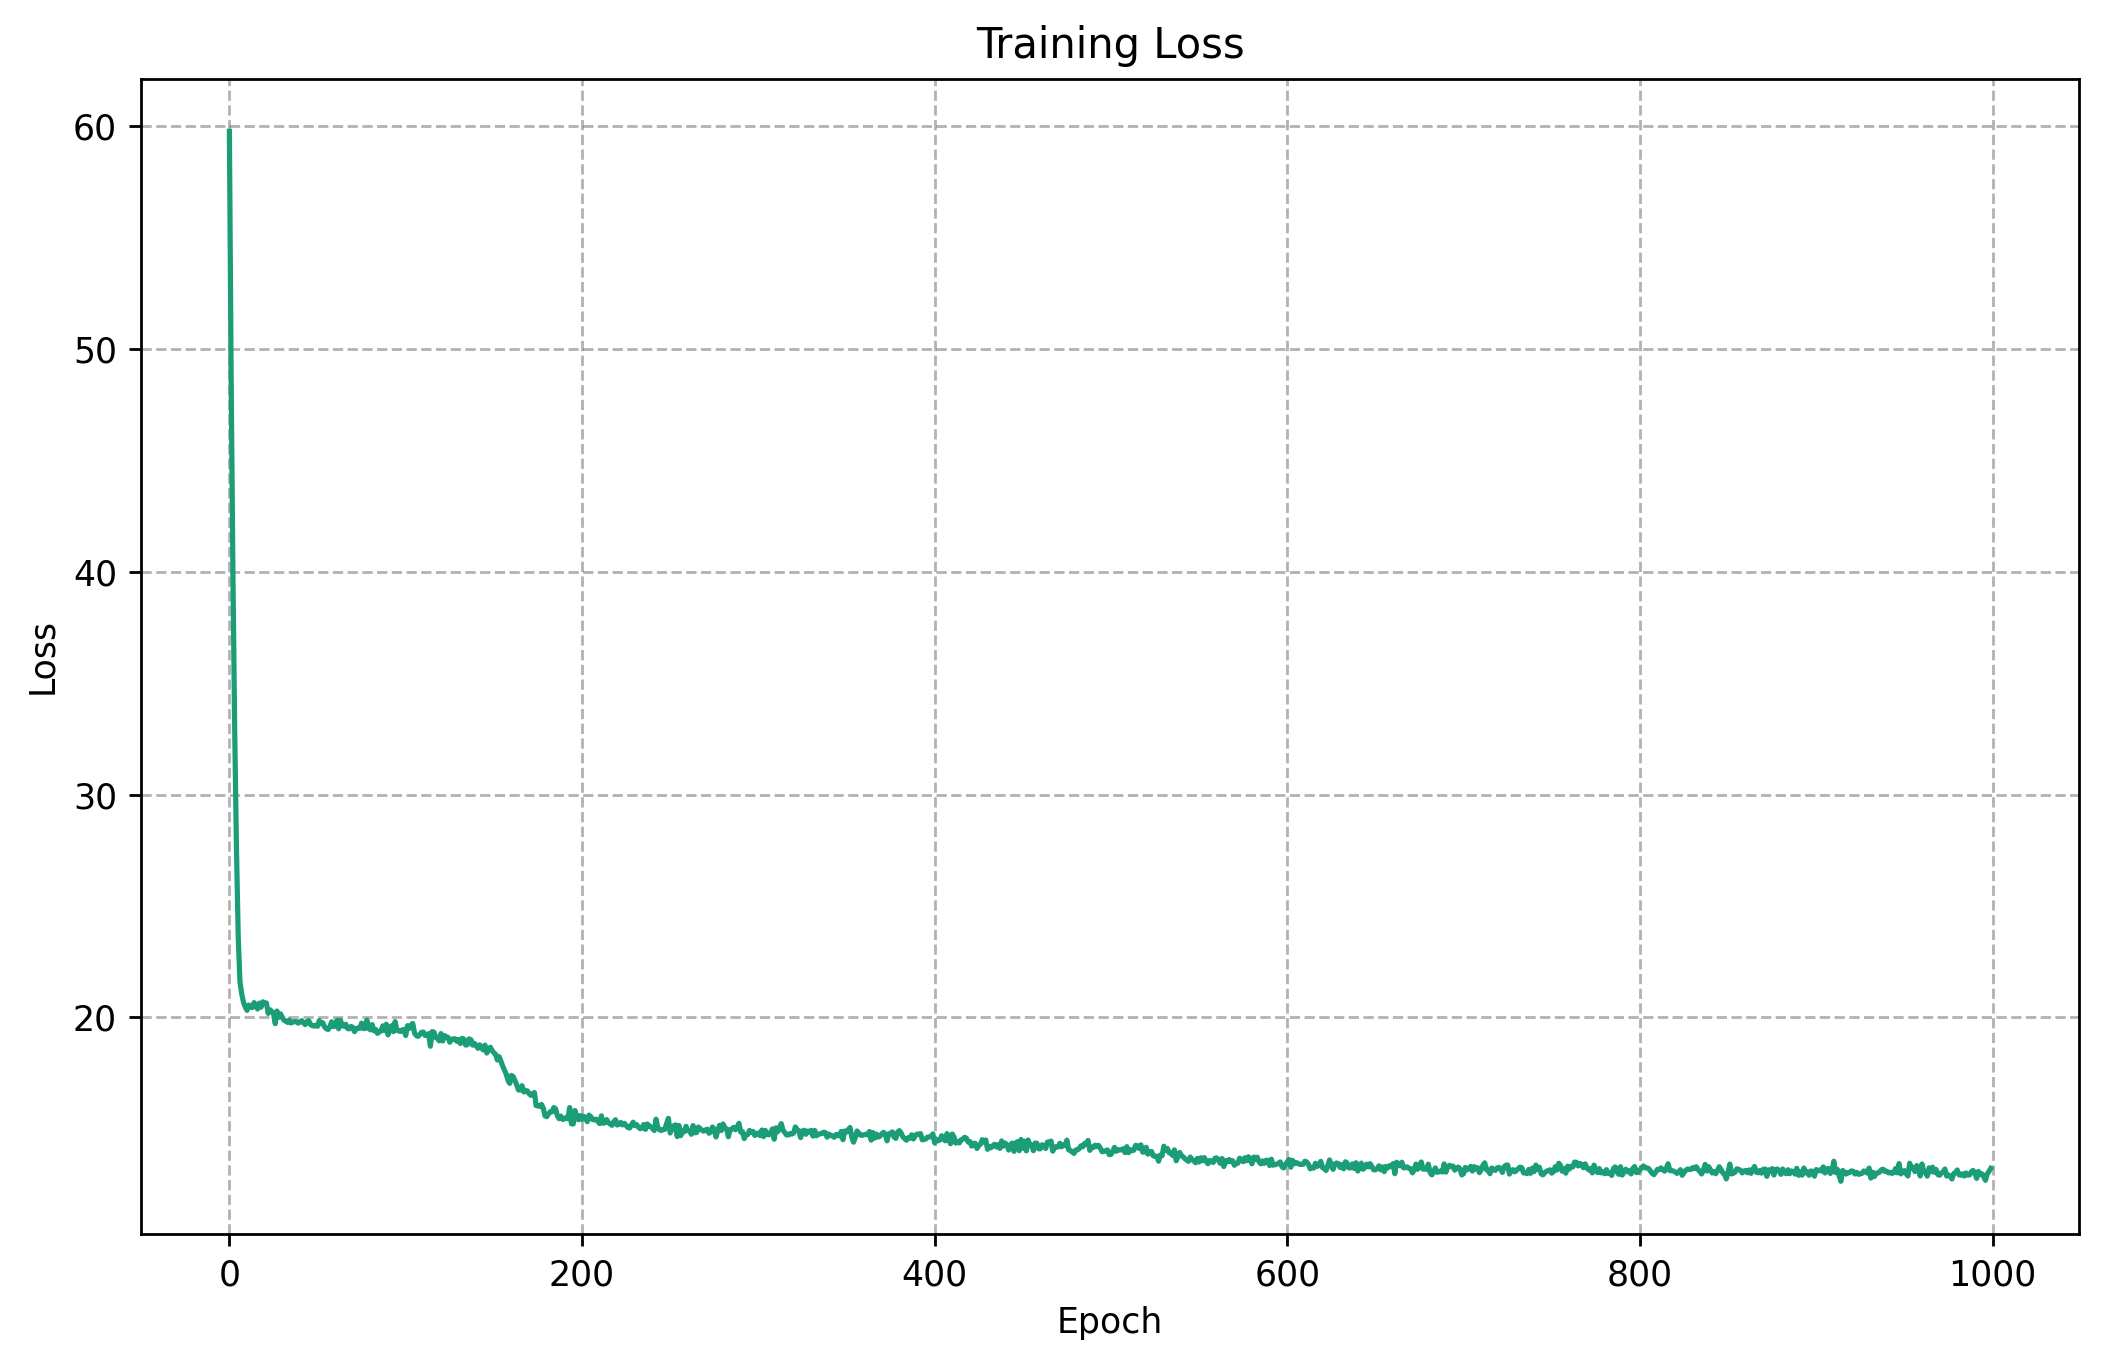

In [8]:
plt.figure(figsize=(10, 6),dpi = 250)
plt.title('Loss Curve',weight = 'bold',size = 20)
plt.plot(loss_history,color = cm.Dark2(0))
plt.grid(linestyle = '--',alpha = 0.3,color = 'black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

AutoRec是深度学习推荐系统的入门模型,用以学习概念,并进行复现.从模型性能而言,该模型比较简单,预测效果不是很好.

相关论文  AutoRec: Autoencoders Meet Collaborative Filtering  https://paperswithcode.com/paper/autorec-autoencoders-meet-collaborative